In [48]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB 

# Building a SMS spam detector

In [49]:
# load the dataset
url = 'https://raw.githubusercontent.com/um-perez-alvaro/Data-Science-Practice/master/Data/sms.tsv.txt'
sms = pd.read_csv(url, sep='\t', header=None, names=['label', 'message'])

In [50]:
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [51]:
# spam example
print(sms[sms.label=='spam'].message.iloc[100])

To review and KEEP the fantastic Nokia N-Gage game deck with Club Nokia, go 2 www.cnupdates.com/newsletter. unsubscribe from alerts reply with the word OUT


In [52]:
# ham example
print(sms[sms.label=='ham'].message.iloc[100])

Hmm...my uncle just informed me that he's paying the school directly. So pls buy food.


In [53]:
sms.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [54]:
# feature matrix/target vector
X = sms.message
y = sms.label

In [55]:
# train/test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [56]:
# initialize the vectorizer (with default parameters)
vect = CountVectorizer(stop_words='english',max_features=1000,min_df=10)

In [57]:
# learn training vocabulary, then use it to create a document-term matrix
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)

In [58]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)

## Naive Bayes model

In [59]:
# import and initialize a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb_clf = MultinomialNB()

In [60]:
# train the model using X_train_dtm 
nb_clf.fit(X_train_dtm, y_train)

MultinomialNB()

In [61]:
# make class predictions for X_test_dtm
y_test_pred = nb_clf.predict(X_test_dtm)

In [62]:
# evaluate the model
from sklearn.metrics import accuracy_score, confusion_matrix

In [63]:
# accuracy
accuracy_score(list(y_test), y_test_pred)

0.9784637473079684

In [64]:
# confusion matrix
confusion_matrix(y_test, y_test_pred)

array([[1192,   12],
       [  18,  171]], dtype=int64)

In [65]:
# print messages text for the false positives (ham incorrectly classified as spam) 
X_test[(y_test=='ham') & (y_test_pred=='spam')]

700              K..u also dont msg or reply to his msg..
3797    They have a thread on the wishlist section of ...
2766             and  picking them up from various points
1290    Hey...Great deal...Farm tour 9am to 5pm $95/pa...
326                      No calls..messages..missed calls
2833                  Its normally hot mail. Com you see!
603                Speaking of does he have any cash yet?
1419                  Lmao. Take a pic and send it to me.
588     Pete can you please ring meive hardly gotany c...
3589    If you were/are free i can give. Otherwise nal...
4490             The new deus ex game comin early next yr
5475    Dhoni have luck to win some big title.so we wi...
Name: message, dtype: object

In [66]:
X_test[3797]

'They have a thread on the wishlist section of the forums where ppl post nitro requests. Start from the last page and collect from the bottom up.'

In [67]:
# print messages text for the false negatives (span incorrectly classified as ham)  
X_test[(y_test=='spam') & (y_test_pred=='ham')]

672     SMS. ac sun0819 posts HELLO:"You seem cool, wa...
5037    You won't believe it but it's true. It's Incre...
3564    Auction round 4. The highest bid is now £54. N...
3864    Oh my god! I've found your number again! I'm s...
5381           You have 1 new message. Call 0207-083-6089
2558    This message is brought to you by GMW Ltd. and...
3574    You won't believe it but it's true. It's Incre...
3272    You have 1 new voicemail. Please call 08719181...
5110      You have 1 new message. Please call 08715205273
2965    Do you ever notice that when you're driving, a...
2248    Back 2 work 2morro half term over! Can U C me ...
2003    TheMob>Yo yo yo-Here comes a new selection of ...
4213    Missed call alert. These numbers called but le...
2941     You have 1 new message. Please call 08712400200.
3460    Not heard from U4 a while. Call me now am here...
3422    Welcome! Please reply with your AGE and GENDER...
955             Filthy stories and GIRLS waiting for your
4514    Money 

In [69]:
# example of false negatives
X_test[4514]

'Money i have won wining number 946 wot do i do next'

## How does Naive Bayes choose between spam and ham

In [70]:
# store the vocabulary of X_train
words = vect.get_feature_names()

In [71]:
len(words)

647

In [72]:
# Naive Bayes counts the number of times each word appears in each class
# Rows represent classes (ham and spam), columns represent words
nb_clf.feature_count_

array([[ 0.,  0.,  0., ..., 27.,  2., 37.],
       [20., 10., 10., ...,  0., 10.,  0.]])

In [73]:
nb_clf.classes_

array(['ham', 'spam'], dtype='<U4')

In [74]:
# number of times each word appears across all ham messages
ham_word_count = nb_clf.feature_count_[0,:]
# number of times each word appears across all spam messages
spam_word_count = nb_clf.feature_count_[1,:]

In [75]:
# create a DataFrame of words with their separate ham and spam counts
words = pd.DataFrame({'word' : words, 'ham' : ham_word_count, 'spam' : spam_word_count}).set_index('word')
words.head()

,ham,spam
word,,
000,0.0,20.0
03,0.0,10.0
04,0.0,10.0
0800,0.0,12.0
08000839402,0.0,11.0


In [76]:
# add 1 to the columns counts to avoid dividing by 0
words.ham = words.ham+1
words.spam = words.spam+1

In [77]:
# convert the ham and spam counts into frequencies
words.ham = words.ham/words.ham.sum()
words.spam = words.spam/words.spam.sum()
words.head()

,ham,spam
word,,
000,0.000062,0.003581
03,0.000062,0.001876
04,0.000062,0.001876
0800,0.000062,0.002217
08000839402,0.000062,0.002046


In [78]:
# calculate the ratio of ham-to-spam and spam-to-ham for each word
words['ham_ratio'] = words.ham/words.spam
words['spam_ratio'] = words.spam/words.ham

In [79]:
# top 20 spam words
words.sort_values(by='spam_ratio', ascending=False).head(5)

,ham,spam,ham_ratio,spam_ratio
word,,,,
claim,0.000062,0.015175,0.004097,244.101279
prize,0.000062,0.012788,0.004861,205.703325
150p,0.000062,0.008525,0.007292,137.135550
tone,0.000062,0.008014,0.007758,128.907417
guaranteed,0.000062,0.006650,0.009349,106.965729


In [80]:
# top 20 ham words
words.sort_values(by='ham_ratio', ascending=False).head(5)

,ham,spam,ham_ratio,spam_ratio
word,,,,
lt,0.014298,0.000171,83.858635,0.011925
gt,0.014174,0.000171,83.129429,0.012029
lor,0.007646,0.000171,44.846140,0.022298
da,0.007460,0.000171,43.752331,0.022856
later,0.006092,0.000171,35.731070,0.027987


## Logistic Regression Model

In [81]:
from sklearn.linear_model import LogisticRegression

In [82]:
log_clf = LogisticRegression()

In [83]:
log_clf.fit(X_train_dtm,y_train)

LogisticRegression()

In [84]:
y_test_pred = log_clf.predict(X_test_dtm)

In [85]:
accuracy_score(y_test,y_test_pred)

0.9755922469490309

In [86]:
confusion_matrix(y_test,y_test_pred)

array([[1202,    2],
       [  32,  157]], dtype=int64)

In [87]:
print(X_test[(y_test == 'spam') & (y_test_pred == 'ham')].iloc[5])

Latest News! Police station toilet stolen, cops have nothing to go on!


<AxesSubplot:>

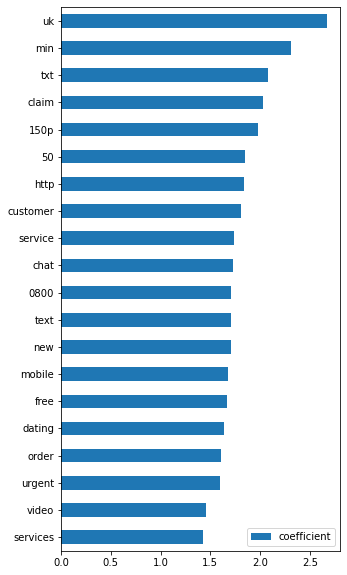

In [90]:
# top coefficients
coeffs = pd.DataFrame(data = log_clf.coef_.T, index=vect.get_feature_names(),columns=['coefficient'])
coeffs.sort_values(by='coefficient').tail(20).plot.barh(figsize=(5,10))

In [91]:
log_clf.classes_

array(['ham', 'spam'], dtype=object)

# From occurrences to frequencies

Occurrence count is a good start but there is an issue: longer documents will have higher average count values than shorter documents, even though they might talk about the same topics.

To avoid these potential discrepancies it suffices to divide the number of occurrences of each word in a document by the total number of words in the document: these new features are called **tf (for Term Frequencies)**.

Another refinement on top of tf is to downscale weights for words that occur in many documents in the corpus and are therefore less informative than those that occur only in a smaller portion of the corpus. This downscaling is called **tf–idf (for “Term Frequency times Inverse Document Frequency”)**.

Both tf and tf–idf can be computed using [TfidfTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer)

In [43]:
from sklearn.feature_extraction.text import TfidfTransformer

In [44]:
# initialize
tf_transformer = TfidfTransformer(use_idf=False) # use tf
# fit
tf_transformer.fit(X_train_dtm)
# transform
X_train_tf = tf_transformer.transform(X_train_dtm)
X_test_tf = tf_transformer.transform(X_test_dtm)

In [45]:
log_clf.fit(X_train_tf,y_train)
y_test_pred = log_clf.predict(X_test_tf)

In [46]:
accuracy_score(y_test,y_test_pred)

0.9720028715003589

In [47]:
confusion_matrix(y_test,y_test_pred)

array([[1211,    2],
       [  37,  143]], dtype=int64)